In [1]:
import tensorflow as tf

import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import numpy as np
import PIL.Image as Image
from keras.preprocessing import image

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

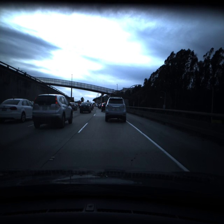

In [3]:
img = Image.open("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/frames/10005.jpg")
img = img.resize((IMAGE_RES,IMAGE_RES))
img

In [4]:
img = np.array(img)/255.0
img.shape

(224, 224, 3)

In [5]:
result = model.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

868

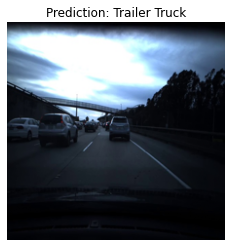

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [8]:
# Create arrays with filenames and lables
inFile = open("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/train-grouped.txt", "r")
filenames = []
lables = []
for i, v in enumerate(inFile):
	filenames.append(str(i)+".jpg")
	lables.append(v)

filenames = tf.constant(filenames)
labels = tf.constant(lables)
labels

#create Dataset
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [9]:
# load images

def im_file_to_tensor(file, label):
    def _im_file_to_tensor(file, label):
        path = f"C:/Users/Lukas/Desktop/commaai-speed-challenge/data/frames/{file.numpy().decode()}"
        decoded_image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        decoded_image = tf.image.resize(decoded_image, (IMAGE_RES, IMAGE_RES))/255.0
        im = tf.cast(decoded_image, tf.float32) / 255.0
        #decoded_image funkar, im är svart
        return decoded_image, int(label)//5
    return tf.py_function(_im_file_to_tensor,
                          inp=(file, label),
                          Tout=(tf.float32, tf.uint8))

dataset = dataset.map(im_file_to_tensor)



In [10]:
#split dataset
train_ds_size = int(0.7 * len(lables))
valid_ds_size = int(0.15 * len(lables))

train_dataset = dataset.take(train_ds_size)
remaining = dataset.skip(train_ds_size)
valid_dataset = remaining.take(valid_ds_size)
test_dataset = remaining.skip(valid_ds_size)

len(train_dataset)

14280

In [11]:
for i, example_image in enumerate(train_dataset.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))  

Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)


In [12]:
BATCH_SIZE = 32

train_batches      = train_dataset.shuffle(len(dataset)//4).batch(BATCH_SIZE , drop_remainder=True).prefetch(1)
validation_batches = valid_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [13]:
def _fixup_shape(images, labels):
    images.set_shape([32, 224, 224, 3])
    labels.set_shape([32]) 
    return images, labels
train_batches = train_batches.map(_fixup_shape)
validation_batches = validation_batches.map(_fixup_shape)

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['racer', 'racer', 'car mirror', 'car mirror', 'traffic light',
       'car mirror', 'car mirror', 'racer', 'car mirror', 'car mirror',
       'volcano', 'volcano', 'car mirror', 'car mirror', 'car mirror',
       'car mirror', 'car mirror', 'car mirror', 'car mirror',
       'car mirror', 'car mirror', 'wing', 'trailer truck', 'racer',
       'car mirror', 'minivan', 'minivan', 'car mirror', 'car mirror',
       'racer', 'traffic light', 'street sign'], dtype='<U30')

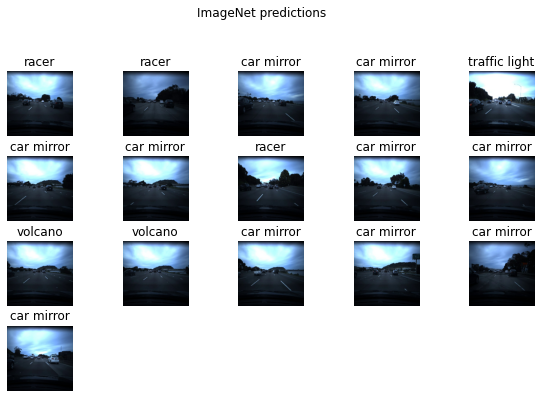

In [15]:
plt.figure(figsize=(10,9))
for n in range(16):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [16]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [17]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [18]:
feature_extractor.trainable = False

In [19]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(7)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [21]:
for i, example_batch in enumerate(train_batches.take(3)):
    print("Batch {} shape images: {} shape lables: {}".format(i+1, example_batch[0].shape, example_batch[1].shape))




Batch 1 shape images: (32, 224, 224, 3) shape lables: (32,)
Batch 2 shape images: (32, 224, 224, 3) shape lables: (32,)
Batch 3 shape images: (32, 224, 224, 3) shape lables: (32,)


In [22]:
EPOCHS = 5
if os.path.exists('model_classify_frames.h5'):
    print("Loading existing model")
    model = load_model('regression_model_test.h5')
else:
    print("Train new model")
    history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)
    #save model
    model.save('model_classify_frames.h5')
    
    #plot results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    


Epoch 1/5
446/446 [==============================] - 739s 2s/step - loss: 0.7139 - accuracy: 0.7355 - val_loss: 2.2977 - val_accuracy: 0.3023
Epoch 2/5
446/446 [==============================] - 616s 1s/step - loss: 0.2852 - accuracy: 0.9141 - val_loss: 2.4484 - val_accuracy: 0.3184
Epoch 3/5
446/446 [==============================] - 610s 1s/step - loss: 0.1929 - accuracy: 0.9484 - val_loss: 3.1758 - val_accuracy: 0.2411
Epoch 4/5
446/446 [==============================] - 662s 1s/step - loss: 0.1417 - accuracy: 0.9660 - val_loss: 3.3692 - val_accuracy: 0.2013
Epoch 5/5
446/446 [==============================] - 761s 2s/step - loss: 0.1087 - accuracy: 0.9767 - val_loss: 3.9162 - val_accuracy: 0.1803


In [30]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = [i * 5 for i in predicted_ids]
predicted_class_names

[25,
 20,
 25,
 30,
 15,
 25,
 25,
 20,
 25,
 25,
 25,
 25,
 25,
 25,
 20,
 15,
 25,
 25,
 20,
 25,
 20,
 25,
 25,
 30,
 25,
 25,
 20,
 25,
 30,
 30,
 20,
 20]

In [31]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [5 4 5 6 4 5 5 4 5 5 5 5 5 5 4 3 5 5 4 5 4 5 5 6 5 5 4 5 6 6 4 4]
Predicted labels:  [5 4 5 6 3 5 5 4 5 5 5 5 5 5 4 3 5 5 4 5 4 5 5 6 5 5 4 5 6 6 4 4]


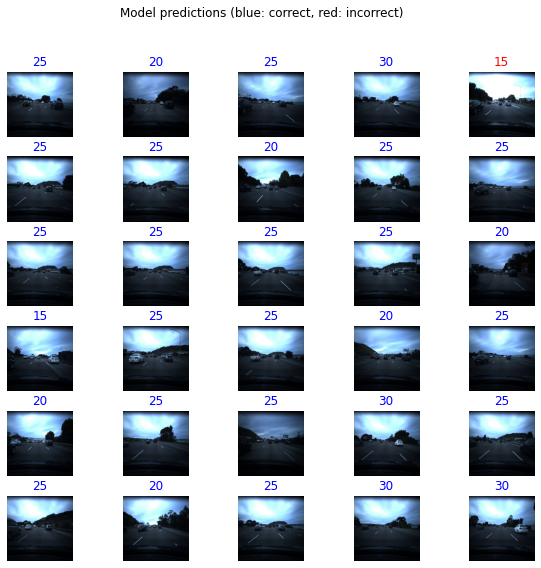

In [34]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n], color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")